In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import os
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, BinaryAccuracy
from keras.losses import mean_squared_error, binary_crossentropy

In [2]:
window_size = 20
path = "spot-the-trend-train-data"
data_count = 1
data = read_data(path,data_count,True)
print(data[0])
memory_usage = data[0].memory_usage(deep=True).sum()

print(f"Memory usage of DataFrame: {memory_usage} bytes")

         Unnamed: 0       time            y  red
0                 0        0.0  2078.992746    0
1                 1        1.0  2078.985492    0
2                 2        2.0  2078.978238    0
3                 3        3.0  2078.970984    0
4                 4        4.0  2078.963729    0
...             ...        ...          ...  ...
1576794     1576794  1576794.0  2104.938032    0
1576795     1576795  1576795.0  2104.935239    0
1576796     1576796  1576796.0  2104.932446    0
1576797     1576797  1576797.0  2104.929653    0
1576798     1576798  1576798.0  2104.926860    0

[1576799 rows x 4 columns]
Memory usage of DataFrame: 50457700 bytes


# The code for a neural network to predict both 'y' and 'red'

In [3]:
window_size = 20
def create_sliding_window_np(y_array, window_size):
    num_windows = len(y_array) - window_size
    
    # Initialize numpy arrays to hold the windows
    X = np.empty((num_windows, window_size))
    y_regression = np.empty((num_windows, 1))
    
    # Use numpy's efficient array slicing
    for i in range(num_windows):
        X[i, :] = y_array[i:i + window_size]
        y_regression[i] = y_array[i + window_size]
    
    return X, y_regression

def process_multiple_dataframes(dataframes, window_size):
    X_total = []
    y_regression_total = []
    y_classification_total = []

    for df in dataframes:
        y_array = df['y'].values
        red_array = df['red'].values[window_size:]  # Adjust to match the length of y_regression
        X, y_regression = create_sliding_window_np(y_array, window_size)
        X_total.append(X)
        y_regression_total.append(y_regression)
        y_classification_total.append(red_array.reshape(-1, 1))

    X_total = np.vstack(X_total)
    y_regression_total = np.vstack(y_regression_total).flatten()
    y_classification_total = np.vstack(y_classification_total).flatten()

    return X_total, y_regression_total, y_classification_total

In [5]:
window_size = 20
path = "spot-the-trend-train-data"
data_count = 4
data = read_data(path,data_count,True)
X, y_regression, y_classification = process_multiple_dataframes(data, window_size)

# Define the model with separate output layers
input_layer = Input(shape=(window_size,))
dense_1 = Dense(64, activation='relu')(input_layer)
dense_2 = Dense(32, activation='relu')(dense_1)

output_regression = Dense(1, name='regression_output')(dense_2)
output_classification = Dense(1, activation='sigmoid', name='classification_output')(dense_2)

model = Model(inputs=input_layer, outputs=[output_regression, output_classification])

# Compile the model with separate losses and metrics
model.compile(optimizer=Adam(),
              loss={'regression_output': mean_squared_error, 'classification_output': binary_crossentropy},
              metrics={'regression_output': MeanSquaredError(), 'classification_output': BinaryAccuracy()})

# Train the model
model.fit(X, {'regression_output': y_regression, 'classification_output': y_classification}, epochs=5, batch_size=32)


Epoch 1/5


2024-06-11 16:48:57.775851: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


197098/197098 [==============================] - 436s 2ms/step - loss: 482.5618 - regression_output_loss: 481.8703 - classification_output_loss: 0.8547 - regression_output_mean_squared_error: 481.8703 - classification_output_binary_accuracy: 0.7948
Epoch 2/5
197098/197098 [==============================] - 176s 891us/step - loss: 14.9959 - regression_output_loss: 14.2186 - classification_output_loss: 0.7762 - regression_output_mean_squared_error: 14.2186 - classification_output_binary_accuracy: 0.8008
Epoch 3/5
197098/197098 [==============================] - 157s 796us/step - loss: 11.4437 - regression_output_loss: 10.7124 - classification_output_loss: 0.7307 - regression_output_mean_squared_error: 10.7124 - classification_output_binary_accuracy: 0.8035
Epoch 4/5
197098/197098 [==============================] - 160s 813us/step - loss: 9.3215 - regression_output_loss: 8.6667 - classification_output_loss: 0.6543 - regression_output_mean_squared_error: 8.6667 - classification_output_bina

# Save the model

In [6]:
# Save the entire model in the SavedModel format
model.save('RedAndY.h5')

In [4]:
from keras.models import load_model

model = load_model('RedAndY.h5')

# predict for the test set

In [7]:
# Define a function to predict on new dataframes and return results as dataframes
def predict_on_dataframes(model, dataframes, window_size):
    prediction_dfs = []
    for df in dataframes:
        #print(df)
        name = df.iloc[1,'name']
        df = df.drop(columns=['name'])
        y_array = df['y'].values
        red_array = df['red'].values
        X, _ = create_sliding_window_np(y_array, window_size)
        y_pred_regression, y_pred_classification = model.predict(X)
        y_pred_classification = (y_pred_classification > 0.5).astype(int)
        # Create a new dataframe with predictions
        prediction_df = pd.DataFrame({
            'name': name,
            'y': y_pred_regression.flatten(),
            'red': y_pred_classification.flatten()
        })
        
        prediction_dfs.append(prediction_df)
    
    return prediction_dfs

path_test = "spot-the-trend-test-data"
data_count = 11
new_data = read_data(path_test,data_count,False)

prediction_dfs = predict_on_dataframes(model, new_data, window_size)


bafgr.csv
edvhp.csv
cnvsw.csv
frlos.csv
dgqzb.csv
dkiqe.csv
ceeng.csv
bzjeg.csv
cuetl.csv
apgjp.csv
oylrn.csv
              time            y  red       name
0              0.0  6939.016924    0  bafgr.csv
1              1.0  6939.031978    0  bafgr.csv
2              2.0  6939.047032    0  bafgr.csv
3              3.0  6939.062086    0  bafgr.csv
4              4.0  6939.077141    0  bafgr.csv
...            ...          ...  ...        ...
1576794  1576794.0  9481.085122    0  bafgr.csv
1576795  1576795.0  9481.084644    0  bafgr.csv
1576796  1576796.0  9481.084166    0  bafgr.csv
1576797  1576797.0  9481.083688    0  bafgr.csv
1576798  1576798.0  9481.083210    0  bafgr.csv

[1576799 rows x 4 columns]
49275/49275 [==============================] - 21s 417us/step
              time            y  red       name
1              1.0  5511.534417    0  edvhp.csv
4              4.0  5511.639696    0  edvhp.csv
21            21.0  5512.236273    0  edvhp.csv
22            22.0  5512.271366 

In [8]:
for df in prediction_dfs:
    print(df)
    interval = df_to_intervals(df)
    print(interval)

              name            y  red
0        bafgr.csv  6940.820312    0
1        bafgr.csv  6940.834961    0
2        bafgr.csv  6940.850098    0
3        bafgr.csv  6940.865234    0
4        bafgr.csv  6940.878906    0
...            ...          ...  ...
1576774  bafgr.csv  9483.264648    0
1576775  bafgr.csv  9483.264648    0
1576776  bafgr.csv  9483.264648    0
1576777  bafgr.csv  9483.264648    0
1576778  bafgr.csv  9483.263672    0

[1576779 rows x 3 columns]
len of intervals is: 0
Empty DataFrame
Columns: [start, stop]
Index: []
              name            y  red
0        edvhp.csv  5515.722656    0
1        edvhp.csv  5515.910645    0
2        edvhp.csv  5516.072266    0
3        edvhp.csv  5516.193359    0
4        edvhp.csv  5516.322266    0
...            ...          ...  ...
1201677  edvhp.csv  2264.340332    0
1201678  edvhp.csv  2264.380615    0
1201679  edvhp.csv  2264.420654    0
1201680  edvhp.csv  2264.460693    0
1201681  edvhp.csv  2264.500732    0

[1201682 ro

# UNDER DEVELOPMENT

In [52]:
def red_blue_intervals(ts,intervals):
    blue = []
    red = []
    blue.append(ts.iloc[0:intervals['start'][0]])
    #print(len(blue))
    for i in range(len(intervals)-1):
        blue.append(ts.iloc[intervals['stop'][i]:intervals['start'][i+1]])
    blue.append(ts.iloc[intervals['stop'][len(intervals)-1]:len(ts)])
    
    for i in range(len(intervals)):
        red.append(ts.iloc[intervals['start'][i]:intervals['stop'][i]])
    blue = pd.concat(blue, ignore_index=False)
    red = pd.concat(red, ignore_index=False)
    return red, blue
test_data = []
for df in prediction_dfs:
    intervals = df_to_intervals(df)
    print(df['red'].any())
    print(intervals)
    # new_df = integrate_intervals(df,intervals)
    # test_data.append(new_df)
    r,b = red_blue_intervals(df,intervals)
    plt.scatter(b.index,b['y'], s=0.001)
    plt.scatter(r.index,r['y'],c='r', s=0.001)
    plt.title(file)
    # plt.savefig("visualisations/"+file.replace('.csv','')+'.png', bbox_inches='tight', dpi=500)
    plt.show()
    plt.close('all')
    gc.collect()


0
False
[]


TypeError: list indices must be integers or slices, not str

# The code for a neural network to predict only 'red'

In [27]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.models import Model
from keras.metrics import MeanSquaredError, BinaryAccuracy
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam

def create_sliding_window_np(y_array, red_array, window_size):
    num_windows = len(y_array) - window_size
    
    # Initialize numpy arrays to hold the windows
    X = np.empty((num_windows, 2 * window_size))
    y_regression = np.empty((num_windows, 1))
    y_classification = np.empty((num_windows, 1))
    
    # Use numpy's efficient array slicing
    for i in range(num_windows):
        X[i, :window_size] = y_array[i:i + window_size]
        X[i, window_size:] = red_array[i:i + window_size]
        y_regression[i] = y_array[i + window_size]
        y_classification[i] = red_array[i + window_size]
    
    return X, y_regression, y_classification

def process_multiple_dataframes(dataframes, window_size):
    X_total = []
    y_regression_total = []
    y_classification_total = []

    for df in dataframes:
        y_array = df['y'].values
        red_array = df['red'].values
        X, y_regression, y_classification = create_sliding_window_np(y_array, red_array, window_size)
        X_total.append(X)
        y_regression_total.append(y_regression)
        y_classification_total.append(y_classification)

    X_total = np.vstack(X_total)
    y_regression_total = np.vstack(y_regression_total).flatten()
    y_classification_total = np.vstack(y_classification_total).flatten()

    return X_total, y_regression_total, y_classification_total


window_size = 20
path = "spot-the-trend-train-data"
data_count = 4
data = read_data(path,data_count)
X, y_regression, y_classification = process_multiple_dataframes(data, window_size)

# Define the model with a single output layer for classification
input_layer = Input(shape=(2 * window_size,))
dense_1 = Dense(64, activation='relu')(input_layer)
dense_2 = Dense(32, activation='relu')(dense_1)

output_classification = Dense(1, activation='sigmoid', name='classification_output')(dense_2)

model = Model(inputs=input_layer, outputs=output_classification)

# Compile the model with classification loss and metrics
model.compile(optimizer=Adam(),
              loss=binary_crossentropy,
              metrics=[BinaryAccuracy()])

# Train the model
model.fit(X, y_classification, epochs=4, batch_size=32)

# Predict the red values
y_classification_pred = model.predict(X)

# Evaluate the model for classification
classification_loss, classification_accuracy = model.evaluate(X, y_classification)
print(f"Classification Loss: {classification_loss}, Classification Accuracy: {classification_accuracy}")

# Evaluate the model for regression (y) separately using MSE
mse = MeanSquaredError()
y_regression_pred = np.zeros_like(y_regression)  # Dummy predictions for y
mse.update_state(y_regression, y_regression_pred)
mse_value = mse.result().numpy()
print(f"Mean Squared Error for y: {mse_value}")


uopfk.csv
mlhdp.csv
ogfyy.csv
pltbp.csv
Epoch 1/4
197098/197098 [==============================] - 84s 425us/step - loss: 0.6113 - binary_accuracy: 0.8466
Epoch 2/4
197098/197098 [==============================] - 83s 421us/step - loss: 0.4464 - binary_accuracy: 0.8359
Epoch 3/4
197098/197098 [==============================] - 84s 426us/step - loss: 0.4464 - binary_accuracy: 0.8359
Epoch 4/4
197098/197098 [==============================] - 54s 274us/step - loss: 0.4458 - binary_accuracy: 0.8359
Classification Loss: 0.4458426833152771, Classification Accuracy: 0.8359227776527405
Mean Squared Error for y: 12297343.0


In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

window_size = 20
path = "spot-the-trend-train-data"
data_count = 4
data = read_data(path,data_count)

# train = np.array([df['y'].to_numpy() for df in data])
# train = np.concatenate(train)
# train = train.flatten().flatten()
# print(train.shape)


# Create input-output pairs
# def create_sliding_window(df, window_size):
#     print('yo')
#     data = df['y'].to_numpy()
#     label = df['red'].to_numpy()
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         # if i%100 == 0:
#         #     print(i)
#         # X.append(list(zip(data[i:i + window_size],label[i:i+window_size])))
#         X.append(data[i:i + window_size])
#         X.append(label[i:i + window_size])
#         y.append(data[i + window_size])
#         y.append(label[i+window_size])
#     print('done')
#     return np.array(X), np.array(y)


# def create_sliding_window(data, window_size):
#     num_windows = len(data) - window_size
    
#     # Create empty arrays to hold the windows
#     X = np.empty((num_windows, 2 * window_size))
#     y = np.empty((num_windows, 2))
    
#     # Use numpy's efficient array slicing
#     for i in range(window_size, len(data)):
#         if i%100000==0:
#             print(i)
#         window_start = i - window_size
#         X[i - window_size, :window_size] = data['y'].iloc[window_start:i]
#         X[i - window_size, window_size:] = data['red'].iloc[window_start:i]
#         y[i - window_size] = [data['y'].iloc[i], data['red'].iloc[i]]
    
#     return X, y

def create_sliding_window_np(y_array, red_array, window_size):
    num_windows = len(y_array) - window_size
    
    # Initialize numpy arrays to hold the windows
    X = np.empty((num_windows, 2 * window_size))
    y = np.empty((num_windows, 2))
    
    # Use numpy's efficient array slicing
    for i in range(num_windows):
        X[i, :window_size] = y_array[i:i + window_size]
        X[i, window_size:] = red_array[i:i + window_size]
        y[i] = [y_array[i + window_size], red_array[i + window_size]]
    
    return X, y

def process_multiple_dataframes(dataframes, window_size):
    X_total = []
    y_total = []

    for df in dataframes:
        y_array = df['y'].values
        red_array = df['red'].values
        X, y = create_sliding_window_np(y_array, red_array, window_size)
        X_total.append(X)
        y_total.append(y)

    X_total = np.vstack(X_total)
    y_total = np.vstack(y_total)

    return X_total, y_total

    
# print(type(train[0]))
# ys = np.array([df['y'].to_numpy() for df in train])
# labels = np.array([df['red'].to_numpy() for df in train])
# X, y = [], []
# for d in data:
#     Xtemp, ytemp = create_sliding_window(d, window_size)
#     X.append(Xtemp)
#     y.append(ytemp)

X, y = process_multiple_dataframes(data, window_size)


# print(X,y)

# X = np.array(X).flatten()
# y = np.array(y).flatten()

print(type(X))
print(len(X))
print(type(y))
print(len(y))

print(np.isnan(X).any())  # Should be False
print(np.isnan(y).any())  # Should be False

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#print()
#print(r2_score(X_train,y_train))
#print(r2_score(X_test,y_test))
#print()

print(np.isnan(X_train).any())  # Should be False
print(np.isnan(y_train).any())  # Should be False
print(np.isinf(X_train).any())  # Should be False
print(np.isinf(y_train).any())  # Should be False

# Define and compile the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2 * window_size,)),
    Dense(32, activation='relu'),
    Dense(2)  # Output layer with 2 neurons for y and red
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=4, batch_size=32)

# Ensure the data is of type float
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')

# # Define the model
# model = Sequential()
# model.add(Dense(40, activation='relu', input_shape=(window_size,)))
# model.add(Dense(2))
# model.compile(optimizer='adam', loss='mse')

# # Train the model
# history = model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), verbose=1)

# # Evaluate the model
# loss = model.evaluate(X_test, y_test, verbose=0)
# print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


uopfk.csv
mlhdp.csv
ogfyy.csv
pltbp.csv
<class 'numpy.ndarray'>
6307116
<class 'numpy.ndarray'>
6307116
False
False
False
False
False
False
Epoch 1/4
109511/197098 [===============>..............] - ETA: 56s - loss: 598.1847

KeyboardInterrupt: 

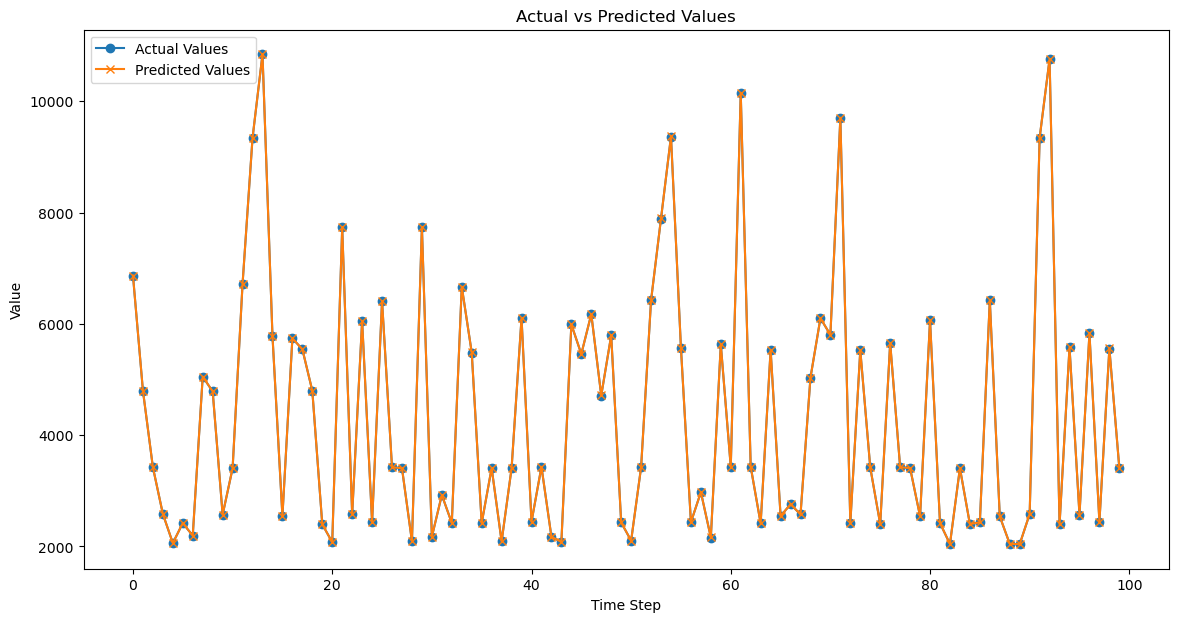

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

plt.figure(figsize=(14, 7))
plt.plot(y_test[1000:1100], label='Actual Values', marker='o')
plt.plot(predictions[1000:1100], label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()